# 1. オペレーティングシステム 演習 14
#  mmapの課題

名前と学生証番号を書け. Enter your name and student ID.

 * 名前 Name: Hartanto Kwee Jeffrey
 * 学生証番号 Student ID: 7V239416

# 2. mmapを利用した高速な検索
* 整列された配列の2分探索をするbsearchというライブラリ関数がある(man bsearch参照)
* 以下は使用例 (配列aが昇順に整列されていることに注意)

In [10]:
%%writefile bsearch.c
#include <stdio.h>
#include <stdlib.h>

int compare_int(const void * a_, const void * b_) {
  const int * a = a_;
  const int * b = b_;
  return *a - *b;
}

int main(int argc, char ** argv) {
  int key = (argc > 1 ? atoi(argv[1]) : 100);
  int a[] = { 100, 200, 300, 400, 500 };
  int n = sizeof(a) / sizeof(a[0]);
  int * found = bsearch(&key, a, n, sizeof(int), compare_int);
  if (found) {
    printf("%d found at %ld-th element\n", key, found - a);
  } else {
    printf("%d not found\n", key);
  }
  return 0;
}

Overwriting bsearch.c


In [11]:
gcc -o bsearch -O3 -Wall bsearch.c

* 実行例

In [12]:
./bsearch 100
./bsearch 200
./bsearch 400
./bsearch 390

100 found at 0-th element
200 found at 1-th element
400 found at 3-th element
390 not found


* 以下で, 多数の32 bit整数が隙間なく, 256M個, 昇順に整列されたファイルを作る (512MB)

In [1]:
#!/usr/bin/python3
import os
import sys
import getpass
import numpy as np

def mk_sorted_file(filename, size):
    assert(size <= 1024 * 1024 * 1024), "don't make it > 4GB"
    rg = np.random.RandomState()
    rg.seed(1234)
    gap = 1024 * 1024 * 1024 / size
    a = rg.randint(0, gap, size=size, dtype=np.uint32)
    s = 0
    for i in range(size):
        s += a[i]
        a[i] = s
    dirname = os.path.dirname(filename)
    if dirname == "":
        dirname = "."
    os.makedirs(dirname, exist_ok=True)
    with open(filename, "wb") as wp:
        a.tofile(wp)

def main():
    filename = sys.argv[1]
    sz = int(sys.argv[2])
    mk_sorted_file(filename, sz)
        
if sys.argv[0].endswith("mk_sorted_file.py"):
    main()


* 多少(20秒くらい)かかるが気長に待つ

In [2]:
n = 256 * 1024 * 1024
mk_sorted_file("sorted.bin", n)

* 確認

In [15]:
ls -l sorted.bin

-rw-r--r-- 1 u23391 u23391 1073741824 Jan  5 22:15 sorted.bin


# <font color="green"> Problem 1 :  mmapの有効な利用</font>

* ファイル名と検索したい整数Kを与えられ, その整数がファイル中にあれば,
```
193659 found at 25850-th element
```
のように, その数(193659)がファイル中の何番目(最初の数を0-th elementとする)であるかを表示し, なければ,
```
19365 not found
```
のように, ないと答えるプログラムを, mmapをbsearchを有効に用いて書け
* マニュアルページなどを参照しながら必要な ヘッダファイルを #include して, 一から書いてみよ

In [16]:

%%writefile mmap_bsearch.c
#include <stdio.h>
#include <stdlib.h>
#include <fcntl.h>
#include <sys/stat.h>
#include <sys/mman.h>
#include <err.h>

int compare_int(const void * a_, const void * b_) {
  const int * a = a_;
  const int * b = b_;
  return *a - *b;
}

int main(int argc, char ** argv) {
  // https://stackoverflow.com/questions/43674522/how-is-char-to-string-literal-valid
  char * filename = (argc > 1 ? argv[1] : "sorted.bin");
  int key = (argc > 2 ? atoi(argv[2]) : 100);
  // int key = 362382304;
  int fd = open(filename, O_RDONLY);
  struct stat st;
  fstat(fd, &st);
  int fd_size = st.st_size;
  // printf("%d\n", fd_size);
  int num_numbers = fd_size / sizeof(int); // divide by 4
  if (num_numbers != 256 * 1024 * 1024) err(-1, "num_numbers");

  int* a = mmap(0, fd_size, PROT_READ, MAP_SHARED, fd, 0);
  if (a == MAP_FAILED) err(1, "mmap");

  int* found = bsearch(&key, a, num_numbers, sizeof(int), compare_int);
  if (found) {
    printf("%d found at %ld-th element\n", key, found - a);
  } else {
    printf("%d not found\n", key);
  }
  return 0;
}

Overwriting mmap_bsearch.c


In [17]:
gcc -o mmap_bsearch -Wall -O3 mmap_bsearch.c

* テスト

In [4]:
data=sorted.bin
if /usr/bin/time ./mmap_bsearch ${data} 362382304 | grep "362382304 found at 241618944-th element" ; then echo OK ; else echo NG ; fi
if /usr/bin/time ./mmap_bsearch ${data} 322162113 | grep "322162113 found at 214802432-th element" ; then echo OK ; else echo NG ; fi
if /usr/bin/time ./mmap_bsearch ${data} 281936687 | grep "281936687 found at 187985920-th element" ; then echo OK ; else echo NG ; fi
if /usr/bin/time ./mmap_bsearch ${data} 241713801 | grep "241713801 found at 161169408-th element" ; then echo OK ; else echo NG ; fi
if /usr/bin/time ./mmap_bsearch ${data} 362382307 | grep "362382307 not found" ; then echo OK ; else echo NG ; fi
if /usr/bin/time ./mmap_bsearch ${data} 322162115 | grep "322162115 not found" ; then echo OK ; else echo NG ; fi
if /usr/bin/time ./mmap_bsearch ${data} 281936688 | grep "281936688 not found" ; then echo OK ; else echo NG ; fi
if /usr/bin/time ./mmap_bsearch ${data} 241713802 | grep "241713802 not found" ; then echo OK ; else echo NG ; fi

362382304 found at 241618944-th element
0.00user 0.00system 0:00.01elapsed 30%CPU (0avgtext+0avgdata 2452maxresident)k
3328inputs+0outputs (13major+72minor)pagefaults 0swaps
OK
322162113 found at 214802432-th element
0.00user 0.00system 0:00.00elapsed 25%CPU (0avgtext+0avgdata 2564maxresident)k
2560inputs+0outputs (11major+75minor)pagefaults 0swaps
OK
281936687 found at 187985920-th element
0.00user 0.00system 0:00.00elapsed 25%CPU (0avgtext+0avgdata 2500maxresident)k
2816inputs+0outputs (11major+75minor)pagefaults 0swaps
OK
241713801 found at 161169408-th element
0.00user 0.00system 0:00.00elapsed 33%CPU (0avgtext+0avgdata 2424maxresident)k
2560inputs+0outputs (10major+75minor)pagefaults 0swaps
OK
362382307 not found
0.00user 0.00system 0:00.00elapsed 50%CPU (0avgtext+0avgdata 2464maxresident)k
0inputs+0outputs (0major+85minor)pagefaults 0swaps
OK
322162115 not found
0.00user 0.00system 0:00.00elapsed 66%CPU (0avgtext+0avgdata 2452maxresident)k
0inputs+0outputs (0major+86minor)pagefau

# <font color="green"> Problem 2 :  readで2分探索</font>

同じ仕様のプログラムを, 「read関数でファイルを大きな配列に全て読み込み, その配列をbsearchで探索する」という方法でも実装せよ

In [77]:

%%writefile read_bsearch.c
#include <stdio.h>
#include <stdlib.h>
#include <fcntl.h>
#include <sys/stat.h>
#include <sys/mman.h>
#include <err.h>
#include <unistd.h>

int compare_int(const void * a_, const void * b_) {
  const int * a = a_;
  const int * b = b_;
  return *a - *b;
}

int main(int argc, char ** argv) {
  char * filename = (argc > 1 ? argv[1] : "sorted.bin");
  int key = (argc > 2 ? atoi(argv[2]) : 100);

  int fd = open(filename, O_RDONLY);
  struct stat st;
  fstat(fd, &st);
  int fd_size = st.st_size;
  int num_numbers = fd_size / sizeof(int); // divide by 4
  if (num_numbers != 256 * 1024 * 1024) err(-1, "num_numbers");

  // Allocate memory dynamically using mmap
  int* a = mmap(0, fd_size, PROT_READ|PROT_WRITE, MAP_PRIVATE|MAP_ANONYMOUS, -1, 0);
  if (a == MAP_FAILED) err(-1, "mmap");
  // int a[256 * 1024 * 1024]; // will segfault

  // Read from the file
  if (read(fd, a, fd_size) == -1) err(-1, "read");

  int* found = bsearch(&key, a, num_numbers, sizeof(int), compare_int);
  if (found) {
    printf("%d found at %ld-th element\n", key, found - a);
  } else {
    printf("%d not found\n", key);
  }

  return 0;
}

Overwriting read_bsearch.c


In [78]:
gcc -o read_bsearch -Wall -O3 read_bsearch.c

In [6]:
data=sorted.bin
if /usr/bin/time ./read_bsearch ${data} 362382304 | grep "362382304 found at 241618944-th element" ; then echo OK ; else echo NG ; fi
if /usr/bin/time ./read_bsearch ${data} 322162113 | grep "322162113 found at 214802432-th element" ; then echo OK ; else echo NG ; fi
if /usr/bin/time ./read_bsearch ${data} 281936687 | grep "281936687 found at 187985920-th element" ; then echo OK ; else echo NG ; fi
if /usr/bin/time ./read_bsearch ${data} 241713801 | grep "241713801 found at 161169408-th element" ; then echo OK ; else echo NG ; fi
if /usr/bin/time ./read_bsearch ${data} 362382307 | grep "362382307 not found" ; then echo OK ; else echo NG ; fi
if /usr/bin/time ./read_bsearch ${data} 322162115 | grep "322162115 not found" ; then echo OK ; else echo NG ; fi
if /usr/bin/time ./read_bsearch ${data} 281936688 | grep "281936688 not found" ; then echo OK ; else echo NG ; fi
if /usr/bin/time ./read_bsearch ${data} 241713802 | grep "241713802 not found" ; then echo OK ; else echo NG ; fi

362382304 found at 241618944-th element
0.00user 0.85system 0:00.86elapsed 98%CPU (0avgtext+0avgdata 1050184maxresident)k
2097152inputs+0outputs (0major+262215minor)pagefaults 0swaps
OK
322162113 found at 214802432-th element
0.00user 0.55system 0:00.55elapsed 99%CPU (0avgtext+0avgdata 1050276maxresident)k
0inputs+0outputs (0major+262217minor)pagefaults 0swaps
OK
281936687 found at 187985920-th element
0.00user 0.52system 0:00.52elapsed 99%CPU (0avgtext+0avgdata 1050200maxresident)k
0inputs+0outputs (0major+262215minor)pagefaults 0swaps
OK
241713801 found at 161169408-th element
0.00user 0.53system 0:00.53elapsed 99%CPU (0avgtext+0avgdata 1050248maxresident)k
0inputs+0outputs (0major+262216minor)pagefaults 0swaps
OK
362382307 not found
0.00user 0.50system 0:00.50elapsed 99%CPU (0avgtext+0avgdata 1050236maxresident)k
0inputs+0outputs (0major+262216minor)pagefaults 0swaps
OK
322162115 not found
0.00user 0.51system 0:00.51elapsed 99%CPU (0avgtext+0avgdata 1050232maxresident)k
0inputs+0out

# <font color="green"> Problem 3 :  線形探索</font>
同じ仕様のプログラムを, 「read関数でファイルを先頭から一定数読んでは, 与えられた値と比較する」ことでも実装せよ

In [33]:

%%writefile lin_search.c
#include <stdio.h>
#include <stdlib.h>
#include <fcntl.h>
#include <sys/stat.h>
#include <sys/mman.h>
#include <err.h>
#include <unistd.h>

int main(int argc, char ** argv) {
  char * filename = (argc > 1 ? argv[1] : "sorted.bin");
  int key = (argc > 2 ? atoi(argv[2]) : 100);

  int fd = open(filename, O_RDONLY);
  struct stat st;
  fstat(fd, &st);
  int fd_size = st.st_size;
  int num_numbers = fd_size / sizeof(int); // divide by 4
  if (num_numbers != 256 * 1024 * 1024) err(-1, "num_numbers");

  // Allocate memory dynamically using mmap
  const int how_many_numbers_read_at_a_time = 1024;
  int a[how_many_numbers_read_at_a_time];
  int numbers_read = 0;

  int found = -1;
  while (numbers_read < num_numbers) {
      if (read(fd, a, how_many_numbers_read_at_a_time * sizeof(int)) != how_many_numbers_read_at_a_time * sizeof(int)) err(-1, "read");
      for (int i = 0; i < how_many_numbers_read_at_a_time; i++) {
          if (a[i] == key) {
              found = numbers_read + i;
              break;
          }
      }
      if (a[how_many_numbers_read_at_a_time - 1] > key) break;
      if (found != -1) break;
      numbers_read += how_many_numbers_read_at_a_time;
  }

  if (found != -1) {
    printf("%d found at %d-th element\n", key, found);
  } else {
    printf("%d not found\n", key);
  }
  return 0;

}

Overwriting lin_search.c


In [34]:
gcc -o lin_search -Wall -O3 lin_search.c

In [35]:
data=sorted.bin
if /usr/bin/time ./lin_search ${data} 362382304 | grep "362382304 found at 241618944-th element" ; then echo OK ; else echo NG ; fi
if /usr/bin/time ./lin_search ${data} 322162113 | grep "322162113 found at 214802432-th element" ; then echo OK ; else echo NG ; fi
if /usr/bin/time ./lin_search ${data} 281936687 | grep "281936687 found at 187985920-th element" ; then echo OK ; else echo NG ; fi
if /usr/bin/time ./lin_search ${data} 241713801 | grep "241713801 found at 161169408-th element" ; then echo OK ; else echo NG ; fi
if /usr/bin/time ./lin_search ${data} 362382307 | grep "362382307 not found" ; then echo OK ; else echo NG ; fi
if /usr/bin/time ./lin_search ${data} 322162115 | grep "322162115 not found" ; then echo OK ; else echo NG ; fi
if /usr/bin/time ./lin_search ${data} 281936688 | grep "281936688 not found" ; then echo OK ; else echo NG ; fi
if /usr/bin/time ./lin_search ${data} 241713802 | grep "241713802 not found" ; then echo OK ; else echo NG ; fi

362382304 found at 241618944-th element
0.16user 0.13system 0:00.30elapsed 99%CPU (0avgtext+0avgdata 1744maxresident)k
0inputs+0outputs (0major+73minor)pagefaults 0swaps
OK
322162113 found at 214802432-th element
0.12user 0.14system 0:00.27elapsed 99%CPU (0avgtext+0avgdata 1604maxresident)k
0inputs+0outputs (0major+71minor)pagefaults 0swaps
OK
281936687 found at 187985920-th element
0.13user 0.10system 0:00.24elapsed 98%CPU (0avgtext+0avgdata 1668maxresident)k
0inputs+0outputs (0major+72minor)pagefaults 0swaps
OK
241713801 found at 161169408-th element
0.11user 0.09system 0:00.21elapsed 99%CPU (0avgtext+0avgdata 1672maxresident)k
0inputs+0outputs (0major+72minor)pagefaults 0swaps
OK
362382307 not found
0.15user 0.15system 0:00.31elapsed 99%CPU (0avgtext+0avgdata 1608maxresident)k
0inputs+0outputs (0major+71minor)pagefaults 0swaps
OK
322162115 not found
0.16user 0.10system 0:00.27elapsed 98%CPU (0avgtext+0avgdata 1608maxresident)k
0inputs+0outputs (0major+72minor)pagefaults 0swaps
OK
28

# <font color="green"> Problem 4 :  速度比較</font>
mmap_bsearch, read_bsearch, lin_search の3つのプログラムを, 実行速度の観点で比較せよ. つまり, (大きなデータに対して)速いと思われる順を 理由とともに述べよ. 実際に実験して確認してみよ


実行速度に関して、早い順にmmap_bsearch, read_bsearch, lin_searchになると思われる。  
mmap_bsearchはファイル全体を読み込むことなく、二分捜索に必要なファイルの部分だけ読み取っているだけである。  
read_bsearchとlin_searchはファイル全体を読んでから捜索を行っているので、読み込みに時間がかかってプログラムが遅くなる。  
さらに、mmap_bsearchは直接キャッシュでデータを保存しているのに対して、read_bsearchとlin_searchはまず二次記憶装置からキャッシュへデータを移して、  
それからキャッシュからRAMにコピーしているので、時間がかかってしまう。  

実験的に確認してみればlin_searchがread_bsearchより早いということがわかる。正確的に、経過時間がlin_searchのほうが早い。  
理論上、線形捜索の平均時間は二分捜索より遅いし、検証に使われいる数字（362382304）は最大の数字（402600476）と桁数一緒で、  
線形捜索はファイルをほぼ最後まで処理していることので線形捜索は遅いはず。    
これはuser時間に反映されている。実際に捜索に使われいる時間は二分捜索のほうが少ないので、user timeはread_bsearchのほうが少ない。   
しかし、read_bsearchとlin_searchの実装を気を付けて読んだら、read_bsearchはmmapを使って一気にファイルを読めるほど大きい配列`a`を作っているのに対して、   
lin_searchは小さめのstaticの配列を作っている。実行中のメモリ割り当てに必要なsystem時間はstatic配列の割り当てよりよっぽど長いので、read_bsearchのsystem時間が長く、   
実行時間のほぼ全部を占めている。



# <font color="green"> Problem 5 :  メモリ使用量比較</font>
mmap_bsearch, read_bsearch, lin_search の3つのプログラムを, メモリ消費量の観点で比較せよ. ファイルが一切キャッシュされていない状態で各プログラムを一度起動した際, 最大でどのくらいのメモリが消費されるか, を比較せよ.


In [7]:
../os11_cache/drop_cache sorted.bin

実験結果を見ると、メモリ消費量の低い順に並ぶと、lin_search (\~1500), mmap_bsearch (\~2500), read_bsearch(\~100000)になる。  
ここでの実装から言うと、lin_searchは一つの配列`a`を何回も同じように最初から最後までループしているだけなので、  
`a`のサイズにかかわらず、OSはこの規則に気づき`a`を常にスワップアウトすることでメモリ消費を抑えている。  
`how_many_numbers_read_at_a_time`をでかい数字(e.g. 1024*1024)にしてもメモリ消費量は少ない(i.e. \~9000)。  
mmap_bsearchとread_bsearchでの配列の読み方は同じで、それが非規則的なので、スワップアウトはlin_searchに比べて少ない。  
両方のスワップアウトの数が同じとして、read_bsearchは配列全体を読み込んでいるので、メモリ消費量はmmap_bsearchより大きい。  

あと、キャッシュされているかどうかは結果にあまり影響しないようである。
以下はファイルのキャッシュを消した後、捜索の一回目と二回目の結果。

1. mmap_bsearch  
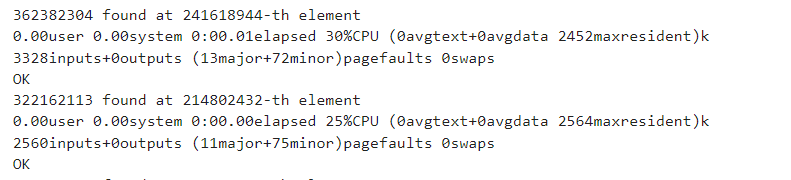　　

2. read_bsearch  
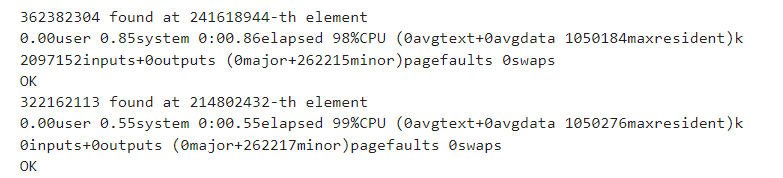  

3. lin_search  
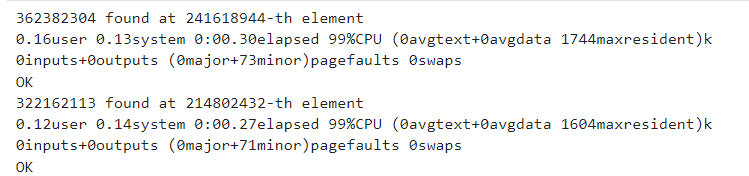